In [2]:
%load_ext autoreload
%autoreload 2

#import chainercv

In [3]:
from chainer.links.model.vision.vgg import VGG16Layers

predictor = VGG16Layers()

In [4]:
#!wget https://gist.githubusercontent.com/yrevar/942d3a0ac09ec9e5eb3a/raw/c2c91c8e767d04621020c30ed31192724b863041/imagenet1000_clsid_to_human.txt

In [5]:
import numpy as np

with open('imagenet1000_clsid_to_human.txt') as f:
    lines = f.readlines()

    
def extract_value(s):
    quote_str = s[s.index(':') + 2]
    return s[s.find(quote_str)+1:s.rfind(quote_str)]

         
classes = np.array([extract_value(line) for line in lines])

In [6]:
classes

array(['tench, Tinca tinca', 'goldfish, Carassius auratus',
       'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias',
       'tiger shark, Galeocerdo cuvieri', 'hammerhead, hammerhead shark',
       'electric ray, crampfish, numbfish, torpedo', 'stingray', 'cock',
       'hen', 'ostrich, Struthio camelus',
       'brambling, Fringilla montifringilla',
       'goldfinch, Carduelis carduelis',
       'house finch, linnet, Carpodacus mexicanus', 'junco, snowbird',
       'indigo bunting, indigo finch, indigo bird, Passerina cyanea',
       'robin, American robin, Turdus migratorius', 'bulbul', 'jay',
       'magpie', 'chickadee', 'water ouzel, dipper', 'kite',
       'bald eagle, American eagle, Haliaeetus leucocephalus', 'vulture',
       'great grey owl, great gray owl, Strix nebulosa',
       'European fire salamander, Salamandra salamandra',
       'common newt, Triturus vulgaris', 'eft',
       'spotted salamander, Ambystoma maculatum',
       'axo

In [7]:
from PIL import Image
import numpy as np

import chainer
import chainer.functions as F

img = Image.open('./input/pexels-photo-945471.jpeg')
x = chainer.links.model.vision.vgg.prepare(img)
print('img', np.asarray(img.convert('RGB')).shape)
print('x', x.shape)
x = x[np.newaxis] # batch size

with chainer.using_config('train', False):
    result = predictor(x)
#prob = F.softmax(result['prob'], axis=1)
prob = result['prob']

lables_pred = np.argsort(prob.array)[0, ::-1]
# F.argmax(prob, axis=1)

img (440, 640, 3)
x (3, 224, 224)


In [8]:
classes[lables_pred[:10]]

array(['basketball', 'punching bag, punch bag, punching ball, punchball',
       'rugby ball', 'barrel, cask', 'barbell',
       'drum, membranophone, tympan', 'gong, tam-tam', 'volleyball',
       "jack-o'-lantern", 'baseball'], dtype='<U121')

In [9]:
# basketball, bus, dog
image_paths = ['./input/pexels-photo-945471.jpeg', './input/pexels-photo-45923.jpeg', './input/pexels-photo-58997.jpeg']

imgs = [Image.open(fp) for fp in image_paths]
x = np.asarray([chainer.links.model.vision.vgg.prepare(img) for img in imgs])


In [10]:
import matplotlib.pyplot as plt

for img in imgs:
    plt.figure()
    plt.imshow(img)
    plt.show()

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

In [11]:
labels = [430]

In [12]:
with chainer.using_config('train', False):
    result = predictor.forward(x, layers=['fc8', 'prob'])
#prob = F.softmax(result['prob'], axis=1)
print('result', result.keys())
prob = result['prob']

lables_pred = np.argsort(prob.array, axis=1)[:, ::-1]

result dict_keys(['fc8', 'prob'])


In [13]:
for i in range(len(lables_pred)):
    print('i', i, 'labels_pred', lables_pred[i, :5], classes[lables_pred[i, :5]])

i 0 labels_pred [430 747 768 427 422] ['basketball' 'punching bag, punch bag, punching ball, punchball'
 'rugby ball' 'barrel, cask' 'barbell']
i 1 labels_pred [867 705 829 555 874] ['trailer truck, tractor trailer, trucking rig, rig, articulated lorry, semi'
 'passenger car, coach, carriage'
 'streetcar, tram, tramcar, trolley, trolley car'
 'fire engine, fire truck' 'trolleybus, trolley coach, trackless trolley']
i 2 labels_pred [253 263 173 273 227] ['basenji' 'Pembroke, Pembroke Welsh corgi' 'Ibizan hound, Ibizan Podenco'
 'dingo, warrigal, warragal, Canis dingo' 'kelpie']


In [14]:
import chainer.functions as F
from chainer import cuda

def eval_fun(x):
    result = predictor.forward(x, layers=['fc8'])
    #result = predictor(x)
    #prob = F.softmax(result['prob'], axis=1)
    out = result['fc8']
    xp = cuda.get_array_module(out.array)
    labels_pred = xp.argmax(out.array, axis=1).astype(xp.int32)
    print('out', out.shape, 'labels_pred', labels_pred.shape)
    loss = F.softmax_cross_entropy(out, labels_pred)
    return loss

In [15]:
#eval_fun(x)

In [16]:
import numpy as np
from chainer_chemistry.datasets.numpy_tuple_dataset import NumpyTupleDataset

# All dataset is to train for simplicity
dataset = NumpyTupleDataset(x)

## Saliency visualization

In [17]:
from chainer_saliency.calculator.gradient_calculator import GradientCalculator
from chainer_saliency.calculator.integrated_gradients_calculator import IntegratedGradientsCalculator
from chainer_saliency.link_hooks.variable_monitor_link_hook import VariableMonitorLinkHook


# 1. instantiation
gradient_calculator = GradientCalculator(predictor, eval_fun=eval_fun)
#gradient_calculator = IntegratedGradientsCalculator(classifier, steps=3,



In [ ]:
# --- VanillaGrad ---
# 2. compute
saliency_arrays_vanilla = gradient_calculator.compute_vanilla(x)
# 3. transform
saliency_vanilla = gradient_calculator.aggregate(
    saliency_arrays_vanilla, ch_axis=2, method='abs')
# saliency_arrays (1, 28, 43, 64) -> M, minibatch, max_atom, ch_dim
print('saliency_arrays', saliency_arrays_vanilla.shape)
# saliency (28, 43) -> minibatch, max_atom
print('saliency', saliency_vanilla.shape)

out (3, 1000) labels_pred (3,)
saliency_arrays (1, 3, 3, 224, 224)
saliency (3, 224, 224)


In [ ]:
M = 5

# --- SmoothGrad ---
# 2. compute
saliency_arrays_vanilla = gradient_calculator.compute_smooth(x, M=M)

print('saliency_arrays', saliency_arrays_vanilla.shape)

out (3, 1000) labels_pred (3,)
out (3, 1000) labels_pred (3,)
out (3, 1000) labels_pred (3,)
out (3, 1000) labels_pred (3,)


In [ ]:
# 3. transform
saliency_vanilla = gradient_calculator.aggregate(
    saliency_arrays_vanilla, ch_axis=2, method='abs')

print('saliency', saliency_vanilla.shape)

In [ ]:
from chainer_saliency.visualizer.image_visualizer import ImageVisualizer
from chainer_saliency.visualizer.common import normalize_scaler

for index in range(len(saliency_vanilla))
    image = imgs[index].resize(saliency_vanilla[index].shape)
    visualizer = ImageVisualizer()
    visualizer.visualize(saliency_vanilla[index], image, show_colorbar=False)

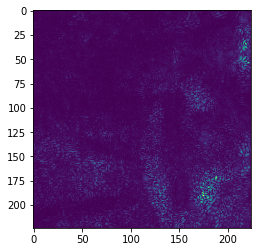

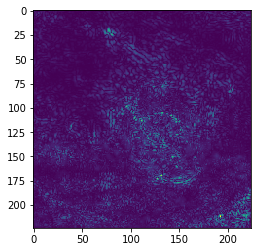

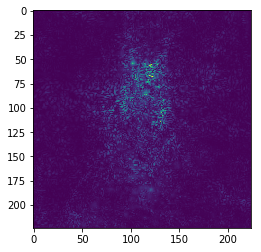

In [109]:
from chainer_saliency.visualizer.common import abs_max_scaler



for index in range(3):
    #saliency_gray = np.sum(saliency_vanilla, axis=1)
    saliency_gray = saliency_vanilla
    #saliency_img = np.transpose(saliency_vanilla[0], (1, 2, 0))
    saliency_img = saliency_gray[index]
    saliency_img2 = abs_max_scaler(saliency_img)

    plt.figure()
    plt.imshow(saliency_img2)
    plt.show()

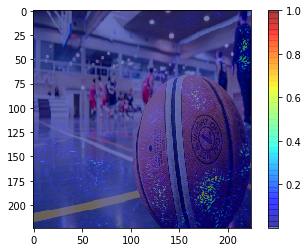

In [113]:
import matplotlib.cm as cm


# 2 images on same ax
index = 0

#saliency_gray = np.sum(saliency_vanilla, axis=1)
saliency_gray = saliency_vanilla
#saliency_img = np.transpose(saliency_vanilla[0], (1, 2, 0))
saliency_img = saliency_gray[index]
saliency_img2 = abs_max_scaler(saliency_img)
fig = plt.figure()
plt.imshow(imgs[index].resize(saliency_img2.shape))
im = plt.imshow(saliency_img2, alpha=0.5, cmap=cm.jet)
fig.colorbar(im)
plt.show()

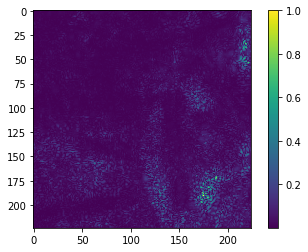

In [123]:


fig = plt.figure()
#plt.imshow(np.array(imgs[index].resize(saliency_img2.shape)))
im = plt.imshow(saliency_img2, alpha=0.5, cmap=cm.jet)
fig.colorbar(im)
plt.show()

In [116]:
im = imgs[index]

In [ ]:
im.

In [128]:
type(image)

PIL.Image.Image

In [126]:
type(imgs[0])

PIL.JpegImagePlugin.JpegImageFile

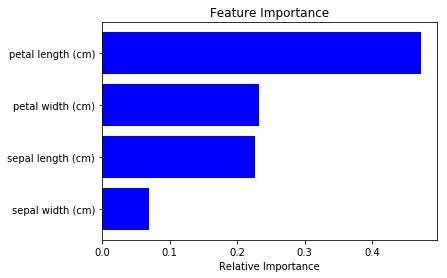

In [65]:
from chainer_saliency.visualizer.table_visualizer import TableVisualizer
from chainer_saliency.visualizer.common import normalize_scaler

visualizer = TableVisualizer()
visualizer.visualize(saliency_vanilla_mean, feature_names=iris.feature_names, num_visualize=-1,
                    scaler=normalize_scaler)